In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection


Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
 73% 11.0M/15.1M [00:00<00:00, 36.9MB/s]
100% 15.1M/15.1M [00:00<00:00, 49.8MB/s]


In [6]:
!unzip -q brain-mri-images-for-brain-tumor-detection.zip


In [7]:
import os
import shutil
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

In [30]:
dataset_path = '/content/brain_tumor_dataset'

paths = []
labels = []

for label in ['yes','no']:
    for dirname, _, filenames in os.walk(os.path.join(dataset_path,label)):
        for filename in filenames:
            paths.append(os.path.join(dirname, filename))
            labels.append(1 if label is 'yes' else 0)

len(paths), len(labels)

<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-30-d493d32b8b7f>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
  labels.append(1 if label is 'yes' else 0)


(253, 253)

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import gc
from torch.utils.data import DataLoader, Dataset

In [32]:
sizes = []
for path in paths:
    im = Image.open(path)
    sizes.append(im.size)
    im.close()

print(max(sizes), min(sizes))


(1920, 1080) (150, 198)


In [33]:

X_train, X_test, y_train, y_test = train_test_split(paths,
                                                    labels,
                                                    stratify=labels,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=1357
                                                   )

print(len(X_train), len(X_test))

202 51


In [34]:
class MRIDataset():
    def __init__(self, paths, labels, augmentations=None):
        self.paths = paths
        self.labels = labels

        if augmentations is None:
            self.augmentations = transforms.Compose([transforms.ToTensor()])
        else:
            self.augmentations = augmentations

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):

        label = self.labels[index]

        sample = Image.open(self.paths[index]).convert(mode="RGB")
        sample = self.augmentations(sample)

        return (sample,torch.tensor(label, dtype=torch.long))

In [35]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [36]:
train_dataset = MRIDataset(X_train, y_train, augmentations=train_transform)
test_dataset = MRIDataset(X_test, y_test, augmentations=test_transform)

torch.Size([3, 224, 224])
1


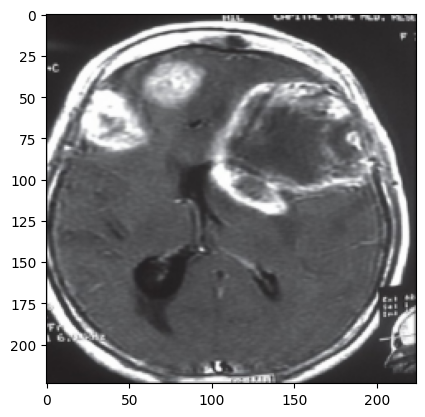

In [37]:
import matplotlib.pyplot as plt

random_sample, random_label = test_dataset[0]
print(random_sample.shape)
plt.imshow(random_sample.permute(1,2,0))
print(random_label.item())

In [38]:
class AttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super(AttentionBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.conv2 = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.conv3 = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        B, C, H, W = x.size()
        query = self.conv1(x).view(B, -1, H * W).permute(0, 2, 1)
        key = self.conv2(x).view(B, -1, H * W)
        attn = self.softmax(torch.bmm(query, key))
        value = self.conv3(x).view(B, -1, H * W)
        out = torch.bmm(value, attn.permute(0, 2, 1)).view(B, C, H, W)
        return out + x



In [39]:
# Define the CNN with Attention
class AttentionCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(AttentionCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        self.att1 = AttentionBlock(64)
        self.att2 = AttentionBlock(128)
        self.att3 = AttentionBlock(256)
        self.att4 = AttentionBlock(512)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(1, blocks):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.att1(x)

        x = self.layer2(x)
        x = self.att2(x)

        x = self.layer3(x)
        x = self.att3(x)

        x = self.layer4(x)
        x = self.att4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x



In [40]:

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [41]:
model = AttentionCNN(num_classes=2)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

AttentionCNN(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, 

In [43]:

num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/30], Loss: 0.9659
Epoch [2/30], Loss: 0.5388
Epoch [3/30], Loss: 0.4900
Epoch [4/30], Loss: 0.4670
Epoch [5/30], Loss: 0.3612
Epoch [6/30], Loss: 0.3803
Epoch [7/30], Loss: 0.3493
Epoch [8/30], Loss: 0.4920
Epoch [9/30], Loss: 0.4703
Epoch [10/30], Loss: 0.3994
Epoch [11/30], Loss: 0.3298
Epoch [12/30], Loss: 0.3522
Epoch [13/30], Loss: 0.2629
Epoch [14/30], Loss: 0.2808
Epoch [15/30], Loss: 0.2663
Epoch [16/30], Loss: 0.2874
Epoch [17/30], Loss: 0.3349
Epoch [18/30], Loss: 0.3094
Epoch [19/30], Loss: 0.2858
Epoch [20/30], Loss: 0.3303
Epoch [21/30], Loss: 0.3165
Epoch [22/30], Loss: 0.3651
Epoch [23/30], Loss: 0.2923
Epoch [24/30], Loss: 0.2552
Epoch [25/30], Loss: 0.3215
Epoch [26/30], Loss: 0.3080
Epoch [27/30], Loss: 0.4485
Epoch [28/30], Loss: 0.2962
Epoch [29/30], Loss: 0.3375
Epoch [30/30], Loss: 0.3080


In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report,roc_curve

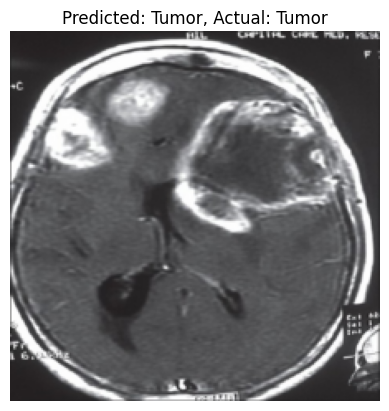

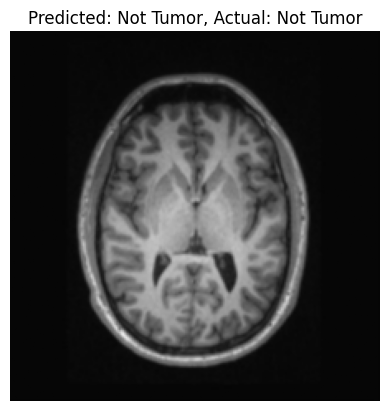

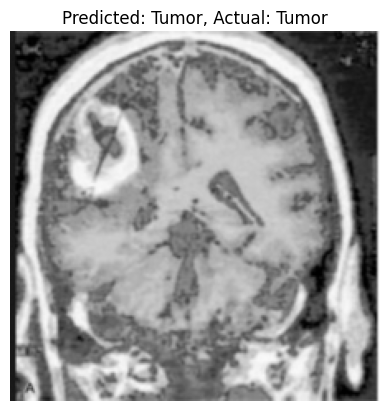

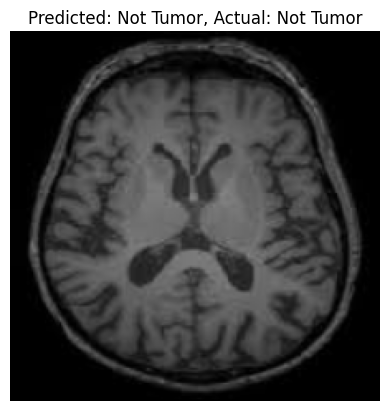

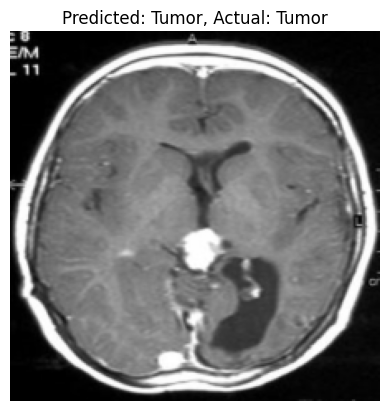

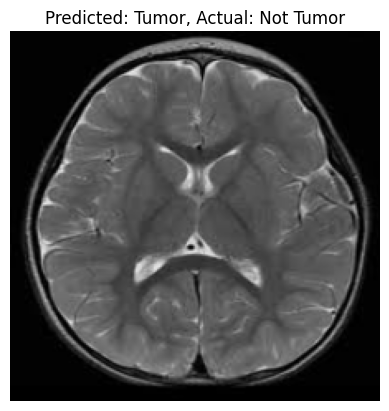

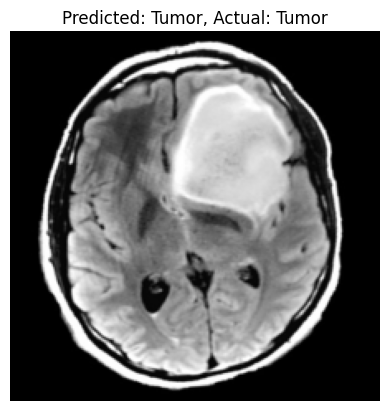

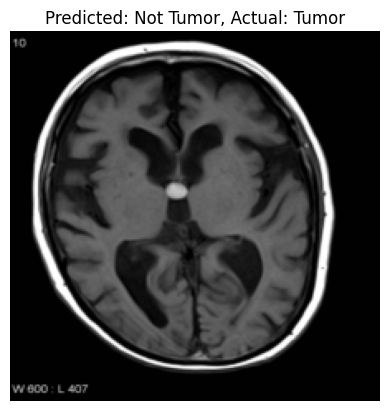

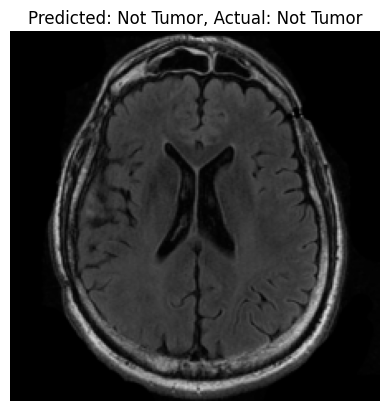

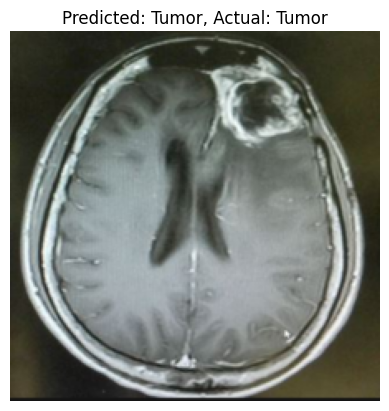

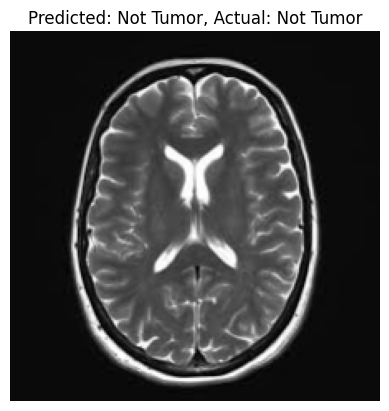

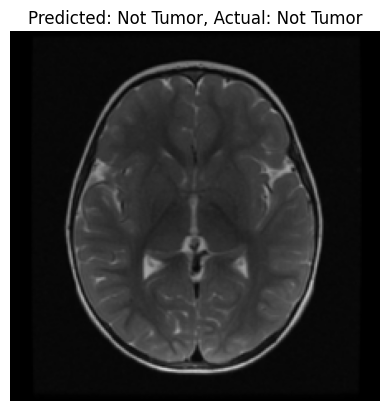

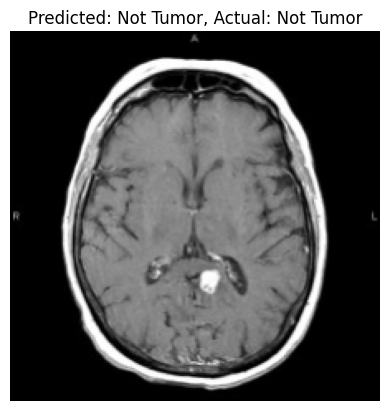

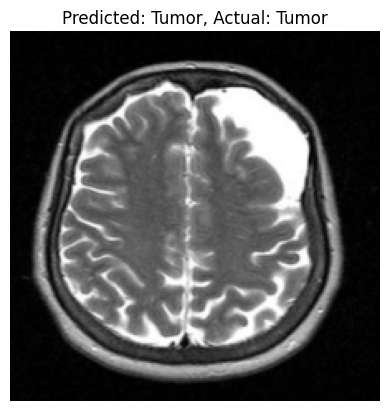

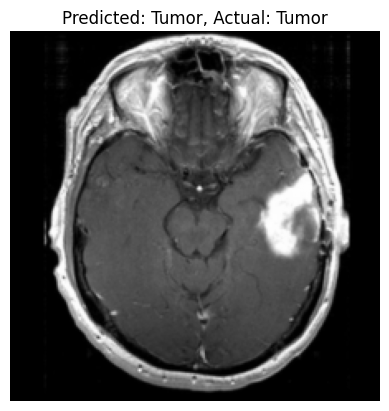

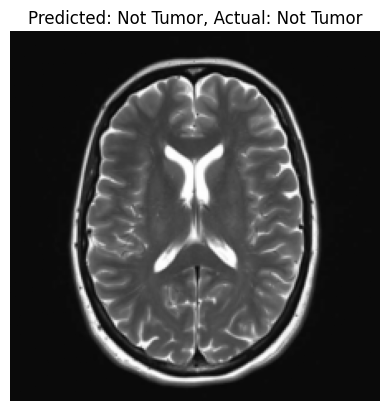

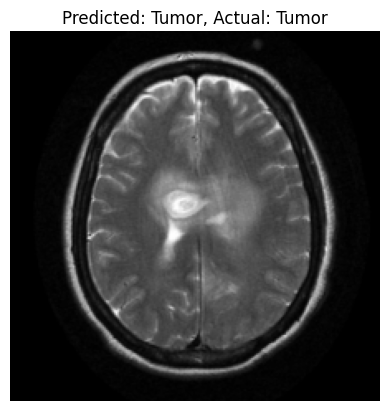

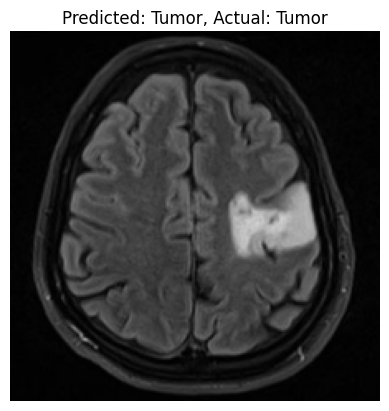

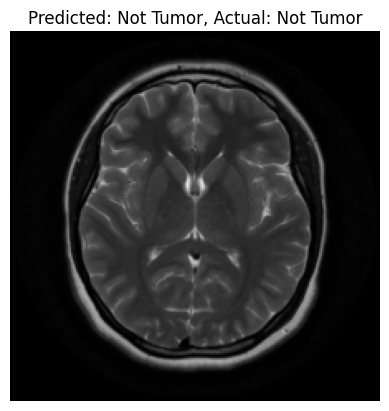

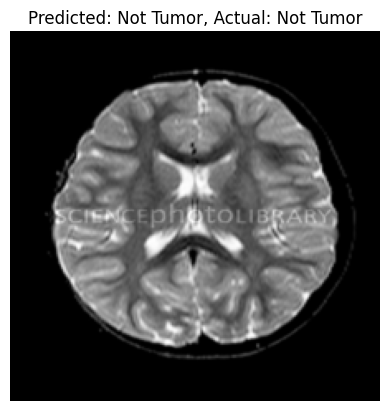

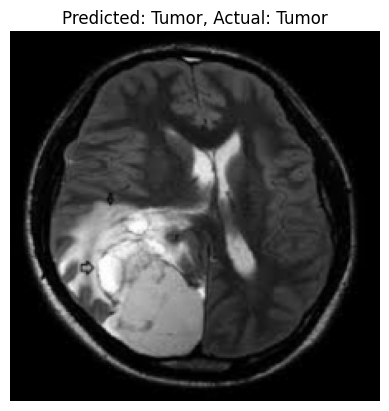

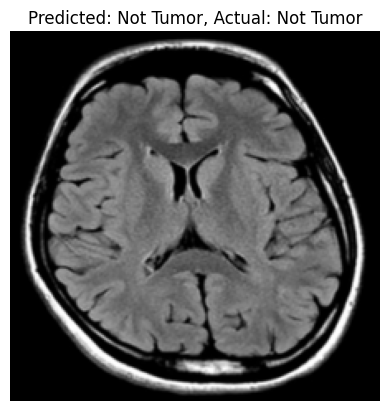

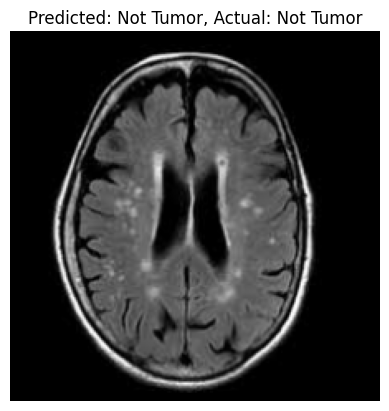

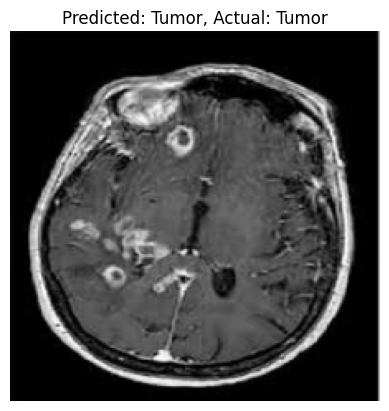

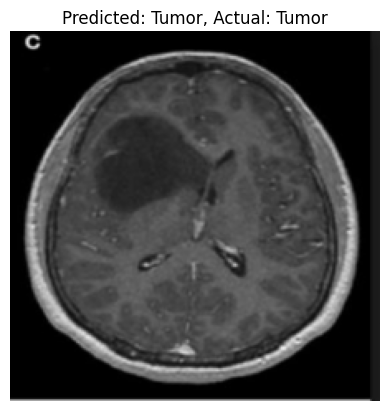

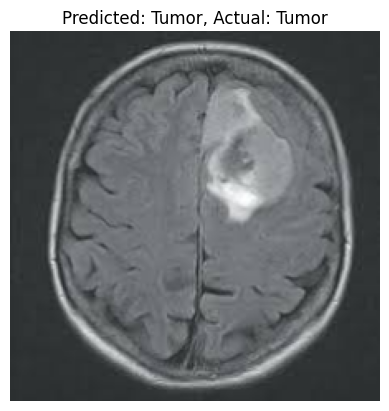

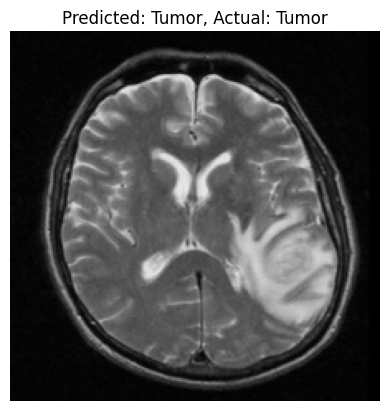

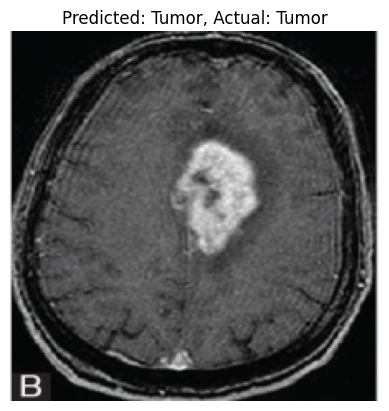

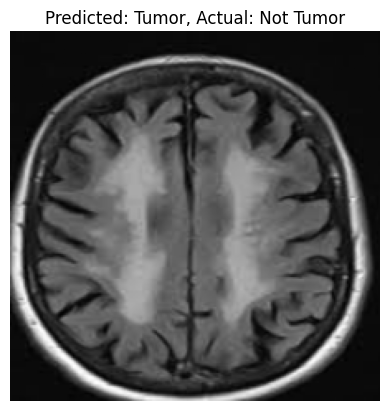

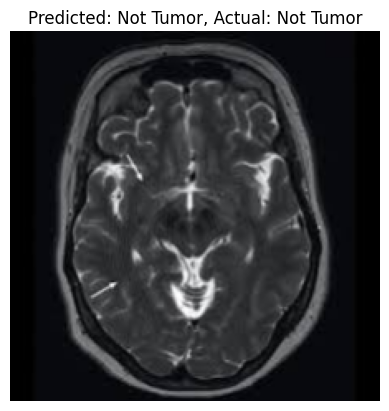

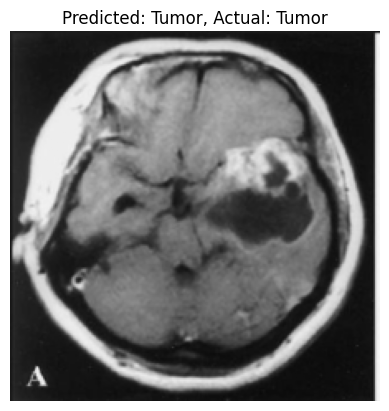

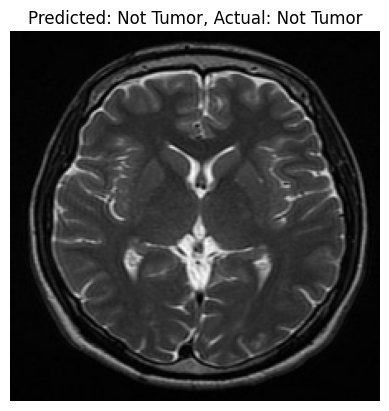

In [54]:
model.eval()
all_labels = []
all_predictions = []
sample_images_shown = False
total = 0
correct = 0


with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).long()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Show sample images with their predicted and actual labels
        if not sample_images_shown:
            sample_images_shown = True
            images_np = images.cpu().numpy()
            predicted_np = predicted.cpu().numpy()
            labels_np = labels.cpu().numpy()

            for i in range(len(images_np)):
                image_np = np.transpose(images_np[i], (1, 2, 0))  # Convert to HxWxC
                plt.imshow(image_np)
                predicted_label = "Tumor" if predicted_np[i] == 1 else "Not Tumor"
                actual_label = "Tumor" if labels_np[i] == 1 else "Not Tumor"
                plt.title(f"Predicted: {predicted_label}, Actual: {actual_label}")
                plt.axis('off')
                plt.show()

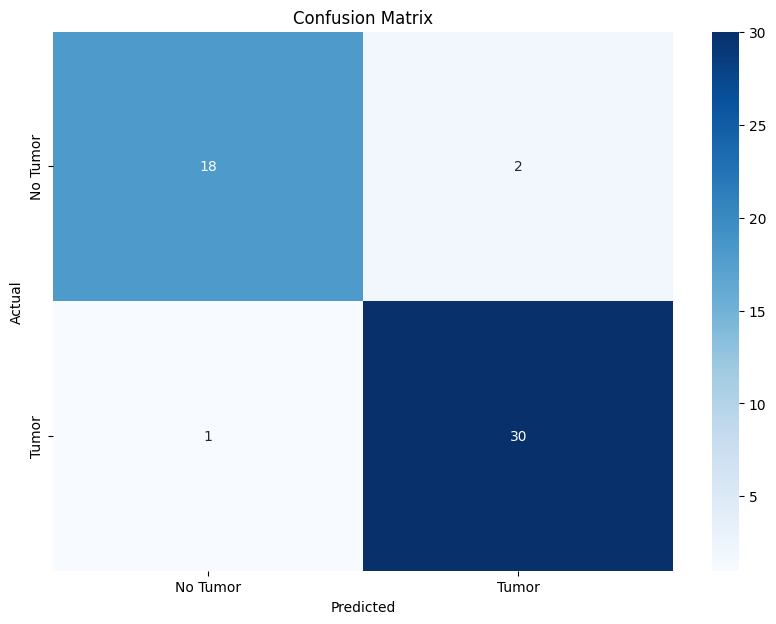

In [53]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Tumor', 'Tumor'], yticklabels=['No Tumor', 'Tumor'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [55]:

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9412
